<a href="https://colab.research.google.com/github/Pojezdal/KNNProject/blob/Ivan/source/KNN_compressai_xrachl00_4conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#KNN Projekt

Denis Pojezdál xpojez00\
Ivan Rachler xrachl00\
Sebastián Chupáč xchupa03



In [1]:
!pip install lpips
!pip install piq
!pip install compressai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyli

Import modules

In [2]:
import time
import piq
import lpips
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
import time
from enum import Enum
import os
import random
import math
from google.colab import drive
import compressai
from compressai.optimizers import net_aux_optimizer
from compressai.models import FactorizedPrior
from compressai.models.utils import conv, deconv
from compressai.layers import GDN, MaskedConv2d
from compressai.entropy_models import EntropyBottleneck, GaussianConditional
drive.mount('/content/drive')

Mounted at /content/drive


Choose device


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


Dataset and dataloader


In [4]:
class DataLoader:
    def __init__(self, dataset, ratio = [0.75, 0.2, 0.05], batch_size = 64, name = None):
        self.dataset = dataset
        train_data, val_data, test_data = torch.utils.data.random_split(dataset, [int(len(dataset) * ratio) for ratio in ratio])
        self.train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        self.val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
        self.test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
        self.batch_size = batch_size
        self.name = name if name is not None else "Not specified"
        print(f"Train size: {len(train_data)}")

stl10_dataset = torchvision.datasets.STL10(root='/content/drive/My Drive/knn_datasets/', split='unlabeled', transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),]
    )
)

stl10 = DataLoader(
    stl10_dataset,
    ratio = [0.8, 0.2, 0.0],
    name = "STL",
)

Train size: 80000


Data augmentation if needed

In [ ]:
#Insert Data augmentation, trainstats, scheduler, if needed

In [5]:
class FactorizedPriorReduced(FactorizedPrior):
    def __init__(self, N, M, **kwargs):
        super().__init__(N, M, **kwargs)

        self.entropy_bottleneck = EntropyBottleneck(M, filters=(3, 3, 3, 3))

        self.g_a = nn.Sequential(
            conv(3, N),
            GDN(N),
            conv(N, N),
            GDN(N),
            conv(N, N),
            GDN(N),
            conv(N, M),
        )

        self.g_s = nn.Sequential(
            deconv(M, N),
            GDN(N, inverse=True),
            deconv(N, N),
            GDN(N, inverse=True),
            deconv(N, N),
            GDN(N, inverse=True),
            deconv(N, 3),
            nn.Sigmoid(),
        )

    @property
    def downsampling_factor(self) -> int:
        return 2**4


In [6]:
class TrainConfig:
    def __init__(self, model, epochs, dataloader, loss_metric, loss_alpha, main_optimizer, aux_optimizer, main_scheduler = None, aux_scheduler = None,
                 save_path = None, custom_name = None, start_epoch = 0, best_loss = float('inf'), loss_transform = None, total_time = 0, load_model = None):
        self.model = model
        self.epochs = epochs
        self.dataloader = dataloader
        self.loss_metric = loss_metric
        self.loss_alpha = loss_alpha
        self.main_optimizer = main_optimizer
        self.aux_optimizer = aux_optimizer
        self.main_scheduler = main_scheduler
        self.aux_scheduler = aux_scheduler
        self.save_path = save_path if save_path else "/content/drive/My Drive/knn_models"
        if not os.path.exists(self.save_path):
            os.makedirs(self.save_path)
        if not os.path.exists(self.save_path + "/logs"):
            os.makedirs(self.save_path + "/logs")
        self.custom_name = custom_name if custom_name else time.strftime("%Y%m%d_%H%M%S")
        self.start_epoch = start_epoch
        self.best_loss = best_loss
        self.loss_transform = loss_transform
        self.total_time = total_time

        self.load_model = load_model
        if self.load_model:
            self.load_from_checkpoint(self.load_model)

    def load_from_checkpoint(self, path):
        checkpoint = torch.load(path, map_location=device)
        self.model.load_state_dict(checkpoint['model_state'])
        self.main_optimizer.load_state_dict(checkpoint['main_optimizer_state'])
        self.aux_optimizer.load_state_dict(checkpoint['aux_optimizer_state'])
        if self.main_scheduler and checkpoint['main_scheduler_state']:
            self.main_scheduler.load_state_dict(checkpoint['main_scheduler_state'])
        if self.aux_scheduler and checkpoint['aux_scheduler_state']:
            self.aux_scheduler.load_state_dict(checkpoint['aux_scheduler_state'])
        self.best_loss = checkpoint['best_loss']
        self.start_epoch = checkpoint['epoch']
        self.total_time = checkpoint['total_time']

In [7]:
normalize_0_1 = torchvision.transforms.Normalize((-1,), (2,)) # from <-1, 1> to <0, 1>
normalize_1_1 = torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

def psnr_bpp(model, dataloader):
    model.update()
    compressed_size = 0
    image_size = 0
    total_psnr = 0
    batch_count = 0
    for batch, _ in dataloader.val_loader:
        images = batch.to(device)
        image_size += images.shape[0] * images.shape[2] * images.shape[3]
        output = model.compress(images)
        for strings in output["strings"]:
            for string in strings:
                compressed_size += len(string) * 8

        images_rec = model.decompress(output["strings"], output["shape"])["x_hat"]
        total_psnr += piq.psnr(images, images_rec).item()
        batch_count += 1

    bpp = compressed_size / image_size
    psnr = total_psnr / batch_count
    return psnr, bpp

Model

In [25]:
model = compressai.zoo.bmshj2018_factorized(quality=3).to(device)
model_reduced = FactorizedPriorReduced(64, 96).to(device)

opt_conf = {
    "net": {"type": "Adam", "lr": 0.001},
    "aux": {"type": "Adam", "lr": 0.001},
}
optimizer = net_aux_optimizer(model_reduced, opt_conf)
main_optimizer = optimizer["net"]
aux_optimizer = optimizer["aux"]
metric_lpips = lpips.LPIPS(net="alex").to(device)
metric_mssim = piq.MultiScaleSSIMLoss(kernel_size = 5).to(device)

train_conf = TrainConfig(
    model = model_reduced,
    epochs = 75,
    dataloader = stl10,
    loss_metric = lambda x_rec, x: metric_lpips(normalize_1_1(x_rec), normalize_1_1(x)).mean() + metric_mssim(x_rec, x),
    loss_alpha = 25,
    main_optimizer = main_optimizer,
    aux_optimizer = aux_optimizer,
    main_scheduler = optim.lr_scheduler.MultiplicativeLR(main_optimizer, lambda epoch: 0.96),
    aux_scheduler = optim.lr_scheduler.MultiplicativeLR(aux_optimizer, lambda epoch: 0.96),
    save_path = "/content/drive/My Drive/knn_models",
    custom_name = "reduced_64_96_4_25_lpips-08_ssim-02_sigm",
    #load_model = "/content/drive/My Drive/knn_models/reduced_64_96_20_lpips_5-ssim_1_best.pth"
)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


Loss function


Loading checkpoint

In [11]:
def save_checkpoint(path : str, model, main_opt, aux_opt, main_sch, aux_sch, best_loss, epoch, total_time):
    torch.save({
        'model_state': model.state_dict(),
        'main_optimizer_state': main_opt.state_dict(),
        'aux_optimizer_state': aux_opt.state_dict(),
        'main_scheduler_state': main_sch.state_dict() if main_sch else None,
        'aux_scheduler_state': aux_sch.state_dict() if aux_sch else None,
        'best_loss': best_loss,
        'epoch': epoch,
        'total_time': total_time,
        },
    path)


def load_checkpoint(path : str, model, main_opt, aux_opt, main_sch, aux_sch):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state'])
    main_opt.load_state_dict(checkpoint['main_optimizer_state'])
    aux_opt.load_state_dict(checkpoint['aux_optimizer_state'])
    if main_sch and checkpoint['main_scheduler_state']:
        main_sch.load_state_dict(checkpoint['main_scheduler_state'])
    if aux_sch and checkpoint['aux_scheduler_state']:
        aux_sch.load_state_dict(checkpoint['aux_scheduler_state'])
    best_loss = checkpoint['best_loss']
    epoch = checkpoint['epoch']
    total_time = checkpoint['total_time']
    return best_loss, epoch, total_time

In [12]:
def log_header(file, conf):
    file.write(f"========= Model =========\n")
    file.write(f"Loaded from checkpoint: {conf.load_model if conf.load_model else 'No'}\n")
    file.write(str(conf.model))
    file.write(f"========= Data Loader =========\n")
    file.write(f"Name: {conf.dataloader.name}\n")
    file.write(f"Batch size: {conf.dataloader.batch_size}\n")
    file.write(f"Training samples: {len(conf.dataloader.train_loader.dataset)}\n")
    file.write(f"Validation samples: {len(conf.dataloader.val_loader.dataset)}\n")
    file.write(f"Test samples: {len(conf.dataloader.test_loader.dataset)}\n")
    file.write(f"========= Loss Function =========\n")
    file.write(f"Metric: {conf.loss_metric._get_name() if hasattr(conf.loss_metric, '_get_name') else conf.loss_metric.__class__.__name__}\n")
    file.write(f"Alpha: {conf.loss_alpha}\n")
    file.write(f"Aux target: {conf.model.entropy_bottleneck.target.tolist()}\n")
    file.write(f"========= Optimizers =========\n")
    file.write(f"Main optimizer: {conf.main_optimizer.__class__.__name__}\n")
    file.write(f"Main learning rate: {conf.main_optimizer.param_groups[0]['lr']}\n")
    file.write(f"Aux optimizer: {conf.aux_optimizer.__class__.__name__}\n")
    file.write(f"Aux learning rate: {conf.aux_optimizer.param_groups[0]['lr']}\n")
    file.write(f"========= Schedulers =========\n")
    file.write(f"Main scheduler: {conf.main_scheduler.__class__.__name__ if conf.main_scheduler else 'None'}\n")
    file.write(f"Main parameters: {conf.main_scheduler.state_dict() if conf.main_scheduler else 'None'}\n")
    file.write(f"Aux scheduler: {conf.main_scheduler.__class__.__name__ if conf.main_scheduler else 'None'}\n")
    file.write(f"Aux parameters: {conf.main_scheduler.state_dict() if conf.main_scheduler else 'None'}\n")
    file.write(f"========= Training =========\n")

def log_epoch(file, index, total, main_loss, dist_loss, bpp_loss, aux_loss, main_lr, aux_lr, time):
    file.write(f"Epoch [{index + 1}/{total}]: main_loss {main_loss:.6f}, distortion {dist_loss:.6f}, bpp {bpp_loss:.6f}, aux_loss {aux_loss:.6f}, main lr {main_lr:.4g}, aux lr {aux_lr:.4g} time {time:.2f}\n")
    file.flush()

def log_finalize(file, best_loss, psnr, bpp, time):
    file.write(f"========= Summary =========\n")
    file.write(f"Best loss: {best_loss:.6f}\n")
    file.write(f"Final psnr: {psnr:.2f}\n")
    file.write(f"Final bpp: {bpp:.4f}\n")
    file.write(f"Total time: {time:.2f}\n")

In [26]:
def loss_function(x, x_recon, likelihoods, metric, alpha, transform = None):
    pixel_count = x.shape[0] * x.shape[2] * x.shape[3]
    if transform:
        distortion = metric(transform(x_recon), transform(x)).mean() * alpha
    else:
        distortion = metric(x_recon, x).mean() * alpha
    bpp = sum((-torch.log(likelihood).sum() / (pixel_count * math.log(2))) for likelihood in likelihoods.values())
    return distortion + bpp, distortion, bpp

Training

In [14]:
def train(conf : TrainConfig):
    log_file = open(f"{conf.save_path}/logs/{conf.custom_name}.log", "w")
    log_header(log_file, conf)

    model, dataloader, loss_metric, loss_alpha, loss_transform = conf.model, conf.dataloader, conf.loss_metric, conf.loss_alpha, conf.loss_transform
    main_optimizer, aux_optimizer, main_scheduler, aux_scheduler = conf.main_optimizer, conf.aux_optimizer, conf.main_scheduler, conf.aux_scheduler
    start_epoch, end_epoch = conf.start_epoch, conf.start_epoch + conf.epochs
    best_loss, total_time = conf.best_loss, conf.total_time
    for epoch in range(start_epoch, end_epoch):
        start_time = time.time()
        model.train()
        for i, (x, _) in enumerate(dataloader.train_loader):
            print(f"\rProcessing batch {i + 1}/{len(dataloader.train_loader)}", end="")
            x = x.to(device)

            output = model(x)
            x_recon = output["x_hat"]
            likelihoods = output["likelihoods"]

            main_loss, _, _ = loss_function(x, x_recon, likelihoods, loss_metric, loss_alpha, loss_transform)

            main_optimizer.zero_grad()
            main_loss.backward()
            main_optimizer.step()

            aux_loss = model.aux_loss()

            aux_optimizer.zero_grad()
            aux_loss.backward()
            aux_optimizer.step()

        model.eval()
        with torch.no_grad():
            for x, _ in dataloader.val_loader:
                x = x.to(device)

                output = model(x)
                x_recon = output["x_hat"]
                likelihoods = output["likelihoods"]

                main_loss, dist_loss, bpp_loss = loss_function(x, x_recon, likelihoods, loss_metric, loss_alpha, loss_transform)
                aux_loss = model.aux_loss()

            end_time = time.time()
            epoch_duration = end_time - start_time
            total_time += epoch_duration
            print(f"\rEpoch [{epoch + 1}/{end_epoch}]: main_loss {main_loss:.6f}, distortion {dist_loss:.6f}, bpp {bpp_loss:.6f}, aux_loss {aux_loss:.6f}, time {epoch_duration:.2f}")
            log_epoch(log_file, epoch, end_epoch, main_loss, dist_loss, bpp_loss, aux_loss, main_optimizer.param_groups[0]['lr'], aux_optimizer.param_groups[0]['lr'], epoch_duration)

        if main_loss < best_loss:
            best_loss = main_loss
            save_checkpoint(f"{conf.save_path}/{conf.custom_name}_best.pth", model, main_optimizer, aux_optimizer, main_scheduler, aux_scheduler, best_loss, epoch, total_time)

        if main_scheduler:
            main_scheduler.step()

        if aux_scheduler:
            aux_scheduler.step()

    psnr, bpp = psnr_bpp(model, dataloader)

    log_finalize(log_file, best_loss, psnr, bpp, total_time)

    save_checkpoint(f"{conf.save_path}/{conf.custom_name}_last.pth", model, main_optimizer, aux_optimizer, main_scheduler, aux_scheduler, best_loss, end_epoch, total_time)


Start training

In [ ]:
train(train_conf)

Epoch [1/75]: main_loss 5.016639, distortion 4.100577, bpp 0.916061, aux_loss 2338.752686, time 122.49
Epoch [2/75]: main_loss 3.584755, distortion 2.666801, bpp 0.917955, aux_loss 2205.758789, time 121.69
Epoch [3/75]: main_loss 3.053622, distortion 2.136524, bpp 0.917098, aux_loss 2256.892822, time 120.53
Epoch [4/75]: main_loss 2.802642, distortion 1.886850, bpp 0.915793, aux_loss 2212.106934, time 122.15
Epoch [5/75]: main_loss 2.641324, distortion 1.727951, bpp 0.913373, aux_loss 1973.916626, time 121.36
Epoch [6/75]: main_loss 2.544711, distortion 1.624510, bpp 0.920201, aux_loss 1628.881470, time 122.56
Processing batch 1161/1250

Inference

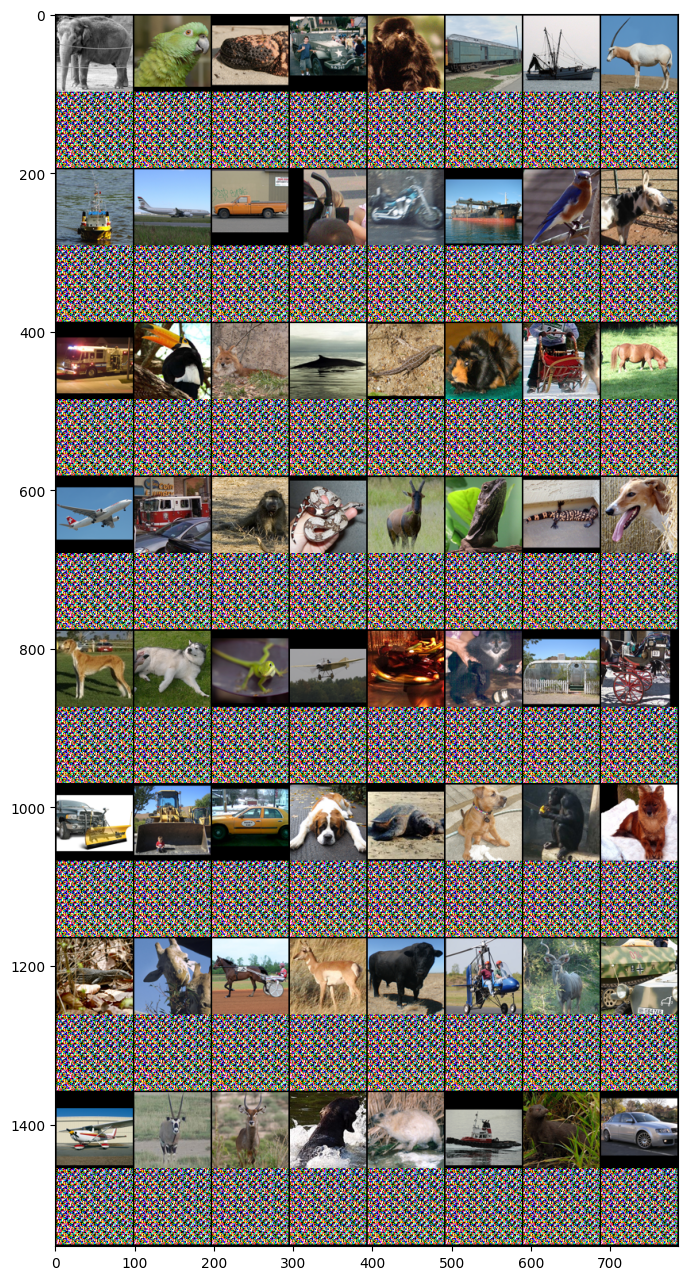

In [24]:
#train_conf.load_from_checkpoint("/content/drive/My Drive/knn_models/reduced_64_96_20_lpips_5-ssim_1_best.pth")
for batch, _ in train_conf.dataloader.val_loader:
    images = batch.to(device)
    output = train_conf.model(images)["x_hat"]
    images = torch.cat((images, output), dim=2)

    npimage = torchvision.utils.make_grid(images).cpu().numpy()
    npimage = npimage.transpose(1, 2, 0)
    plt.figure(figsize=(20, 16))
    plt.imshow(npimage)
    plt.show()
    break


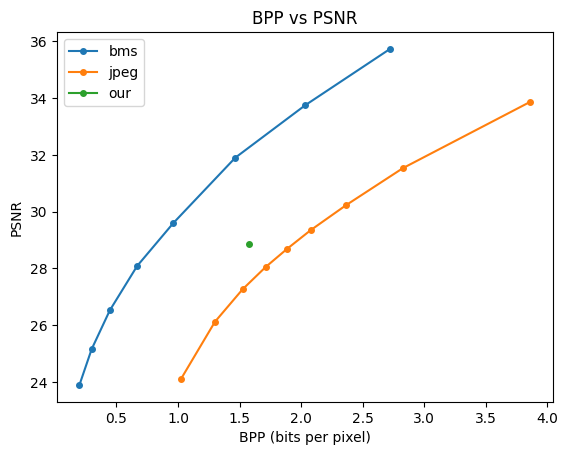

In [17]:
baseline_metrics = {    ## 500 images from the validation set of stl10 dataset (unlabeled split)
"bms": {
    "bpp": [0.19988194444444443, 0.2988402777777776, 0.44673611111111056, 0.6683263888888891, 0.9627986111111108, 1.4655763888888897, 2.0330416666666653, 2.7216875000000007],
    "psnr": [23.897150814056396, 25.15504557800293, 26.526659744262695, 28.087163276672364, 29.60244454574585, 31.903252914428712, 33.75015351486206, 35.73424911880493]},
"jpeg": {
    "bpp": [1.0225347222222223, 1.300105902777778, 1.5240902777777778, 1.7105746527777783, 1.886397569444444, 2.076463541666668, 2.363946180555556, 2.8256059027777805, 3.8610625000000014],
    "psnr": [24.0933437461853, 26.12165872192383, 27.2635897064209, 28.046062282562257, 28.69297319030762, 29.346161067962647, 30.227422931671143, 31.532780990600585, 33.8721844291687]}
}

msssim_baseline_metrics = {
"bms": {
    "bpp": [0.12609027777777776, 0.18234027777777767, 0.2639791666666668, 0.3681875000000006, 0.5104999999999996, 0.6730347222222219, 0.8957916666666671, 1.20357638888889],
    "psnr": [21.257686344146727, 22.253188648223876, 23.349189826965333, 24.287573760986326, 25.30987477874756, 26.3740486907959, 27.460073432922364, 28.656918861389162]},
"jpeg": {
    "bpp": [1.0227777777777778, 1.3023402777777784, 1.5262986111111116, 1.7127708333333331, 1.888520833333333, 2.0786458333333315, 2.365657986111111, 2.8297343749999992, 3.864128472222219],
    "psnr": [24.10634324645996, 26.16938330078125, 27.316714889526367, 28.109992641448976, 28.760773368835448, 29.414331382751463, 30.30017582321167, 31.62249006652832, 34.004099689483645]}
}

psnr, bpp = psnr_bpp(train_conf.model, train_conf.dataloader)
baseline_metrics["our"] = {"bpp": [bpp], "psnr": [psnr]}

def plot_psnr_bpp(model_metrics):
    plt.xlabel('BPP (bits per pixel)')
    plt.ylabel('PSNR')
    plt.title('BPP vs PSNR')
    for model, metrics in model_metrics.items():
        plt.plot(metrics["bpp"], metrics["psnr"], 'o-', markersize=4, label=model)
    plt.legend()
    plt.show()

plot_psnr_bpp(baseline_metrics)

In [18]:
print(baseline_metrics["our"])

{'bpp': [1.5753411458333333], 'psnr': [28.851211346757296]}
